权重衰退是最广泛使用的正则化的技术之一

In [21]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

我们先像以前一样生成一些数据，生成一些公式如下,我们选择标签是关于输⼊的线性函数。标签同时被均值为0，标准差为0.01⾼斯噪声破坏。为了使过拟合的效果更加明显，我们可以将问题的维数增加到d = 200，并使⽤⼀个只包含20个样本的⼩训练集

$y=0.05+\sum_{i=1}^{d} 0.01 x_{i}+\epsilon \text { where } \epsilon \sim \mathcal{N}\left(0,0.01^{2}\right)$

In [22]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

从零开始实现权重衰减，只需将L2的平⽅惩罚添加到原始⽬标函数中。

In [23]:
# 初始化模型参数
def  init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    
    return [w, b]

In [24]:
# 定义 L2 范数惩罚
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [12]:
# 定义训练代码实现
#下⾯的代码将模型拟合训练数据集，并在测试数据集上进⾏评估。从 3节以来，线性⽹络和平⽅损失没有变
# 化，所以我们通过d2l.linreg和d2l.squared_loss导⼊它们。唯⼀的变化是损失现在包括了惩罚项。
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
            if (epoch + 1) % 5 == 0:
                animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 12.775104522705078


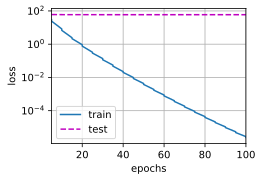

In [13]:
train(lambd=0)

w的L2范数是： 0.35623788833618164


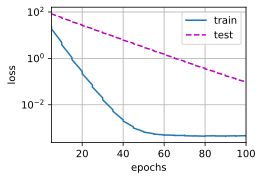

In [14]:
# 使用权重衰减
train(lambd=3)

## 权重衰减的简洁实现

In [27]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_inputs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,(d2l.evaluate_loss(net, train_iter, loss),d2l.evaluate_loss(net, test_iter, loss)))
            
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 14.558565139770508


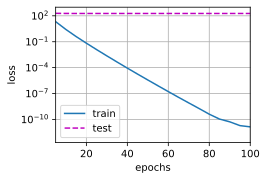

In [28]:
train_concise(0)

w的L2范数： 0.06401798874139786


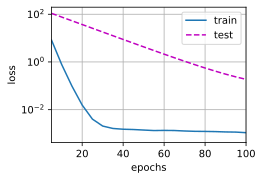

In [29]:
# 有权重衰减
train_concise(3)

## 总结
正则化是处理过拟合的常⽤⽅法：在训练集的损失函数中加⼊惩罚项，以降低学习到的模型的复杂度。
+ 保持模型简单的⼀个特别的选择是使⽤L2惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。
+ 权重衰减功能在深度学习框架的优化器中提供。
+ 在同⼀训练代码实现中，不同的参数集可以有不同的更新⾏为。